In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras.models as models
import keras.layers as layers
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [13]:
def get_initializer(activation: str) -> str:
    if activation == 'relu':
        return 'he_normal'
    else:
        return 'he_uniform'


class CNN:
    def __init__(self,
                 start_filter: int,
                 convolution_filter_multiply: int,
                 convolution_activation: str,
                 dense_vector: int,
                 dense_activation: str):
        self.model = models.Sequential()
        self.model.add(layers.Input((28, 28, 1)))

        # Conv2d
        convolution_initializer = get_initializer(convolution_activation)
        for i in range(2):
            self.model.add(
                layers.Conv2D(filters=start_filter, kernel_size=(3, 3), activation=convolution_activation,
                              kernel_initializer=convolution_initializer))
            start_filter *= convolution_filter_multiply

        # MaxPooling
        for i in range(2):
            self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # Flattering
        self.model.add(layers.Flatten())

        # Dense
        dense_initializer = get_initializer(dense_activation)
        for i in range(2):
            self.model.add(
                layers.Dense(units=dense_vector, activation=dense_activation, kernel_initializer=dense_initializer))

        # final
        self.model.add(layers.Dense(10, activation='softmax'))
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def fit(self, features: np.ndarray, answers: np.ndarray):
        self.model.fit(features, answers, epochs=5, batch_size=10, verbose=0)

    def evaluate(self, features_test: np.ndarray, answers_test: np.ndarray) -> float:
        _, accuracy = self.model.evaluate(features_test, answers_test, verbose=0)
        return accuracy

    def predict(self, feature: np.ndarray):
        return np.argmax(self.model.predict(feature))

    def predict_proba(self, feature: np.ndarray) -> np.ndarray:
        return self.model.predict(feature)

In [4]:
start_filters = [1, 3, 5]
convolutions_filters_multiplies = [1, 2]
convolution_activations = [None, 'relu', 'tanh']
dense_vectors = [50, 100, 200]
dense_activations = ['relu', 'tanh']

In [5]:
best_start_filter = 3
best_convolution_filter_multiply = 1
best_convolution_activation = None
best_dense_vector = 50
best_dense_activation = 'relu'
best_accuracy = 0

for start_filter in start_filters:
    for convolution_filter_multiply in convolutions_filters_multiplies:
        for convolution_activation in convolution_activations:
            for dense_vector in dense_vectors:
                for dense_activation in dense_activations:
                    cnn = CNN(start_filter=start_filter,
                              convolution_filter_multiply=convolution_filter_multiply,
                              convolution_activation=convolution_activation,
                              dense_vector=dense_vector,
                              dense_activation=dense_activation)
                    cnn.fit(X_train, y_train)
                    accuracy = cnn.evaluate(X_test, y_test)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_start_filter = start_filter
                        best_convolution_filter_multiply = convolution_filter_multiply
                        best_dense_vector = dense_vector
                        best_dense_activation = dense_activation

print(f'Лучшее accuracy = {best_accuracy}. Слои модели:')
filter_layers = best_start_filter
for i in range(2):
    print(
        f'Conv2d(filters={filter_layers}, kernel_size=(3, 3), activation={best_convolution_activation},       kernel_initializer={get_initializer(best_convolution_activation)})')
    filter_layers *= best_convolution_filter_multiply
for i in range(2):
    print('MaxPooling2D(pool_size=(2, 2))')
print('Flatten()')
for i in range(2):
    print(
        f'Dense(units={best_dense_vector}, activation={best_dense_activation}, kernel_initializer={get_initializer(best_dense_activation)})')
print('Dense(10, activation=softmax)')

Лучшее accuracy = 0.8865000009536743. Слои модели:
Conv2d(filters=5, kernel_size=(3, 3), activation=None,       kernel_initializer=he_uniform)
Conv2d(filters=10, kernel_size=(3, 3), activation=None,       kernel_initializer=he_uniform)
MaxPooling2D(pool_size=(2, 2))
MaxPooling2D(pool_size=(2, 2))
Flatten()
Dense(units=100, activation=relu, kernel_initializer=he_normal)
Dense(units=100, activation=relu, kernel_initializer=he_normal)
Dense(10, activation=softmax)


In [15]:
best_model = CNN(start_filter=best_start_filter,
                 convolution_filter_multiply=best_convolution_filter_multiply,
                 convolution_activation=best_convolution_activation,
                 dense_vector=best_dense_vector,
                 dense_activation=best_dense_activation)
best_model.fit(X_train, y_train)

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


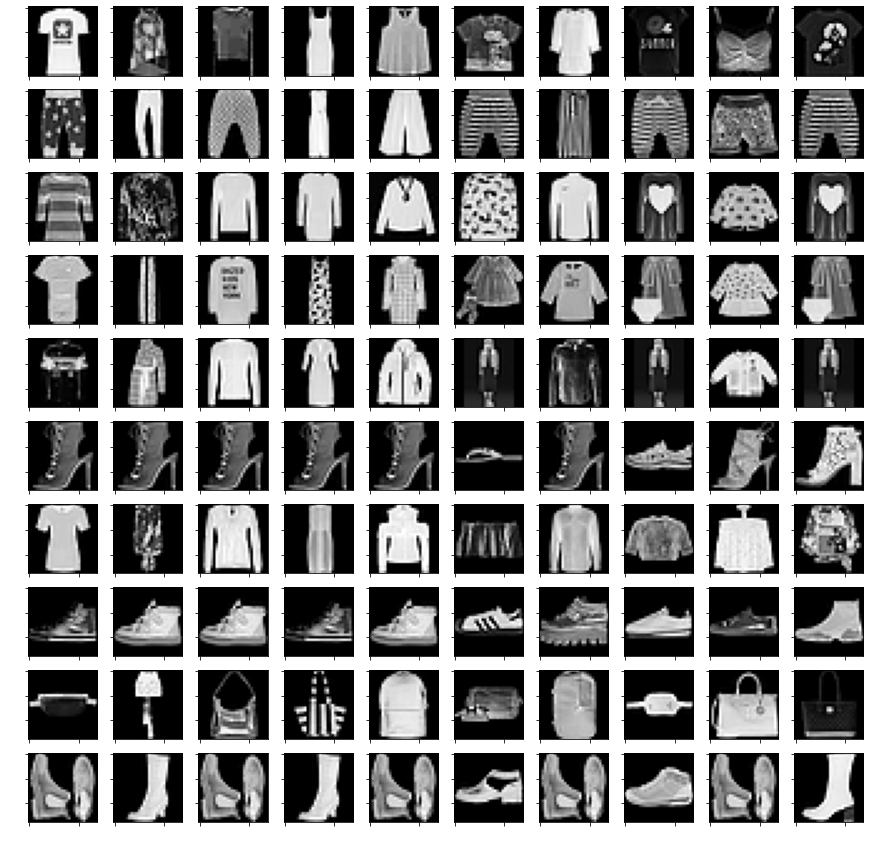

In [32]:
from keras.preprocessing.image import  img_to_array

def show_similar():
    fashion_mnist_dict = {0: 'T-shirt/top',
                          1: 'Trouser',
                          2: 'Pullover',
                          3: 'Dress',
                          4: 'Coat',
                          5: 'Sandal',
                          6: 'Shirt',
                          7: 'Sneaker',
                          8: 'Bag',
                          9: 'Ankle boot'}
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    for i_class in range(10):
        images = [(X_test[i], best_model.predict_proba(img_to_array(X_test[i]).reshape(1, 28, 28, 1))) for i in range(len(X_test)) if y_test[i] == i_class]
        print(len(images))
        for j_class in range(10):
            if j_class == 0:
                axes[i_class][j_class].set_ylabel(fashion_mnist_dict[i_class])
                axes[i_class][j_class].yaxis.label.set_color('white')
            if i_class == 9:
                axes[i_class][j_class].set_xlabel(fashion_mnist_dict[j_class])
                axes[i_class][j_class].xaxis.label.set_color('white')
            most_similar = images[np.argmax([images[i][1].take(j_class) for i in range(len(images))])][0]
            axes[i_class][j_class].imshow(most_similar, cmap=plt.get_cmap('gray'))
            axes[i_class][j_class].set_yticklabels([])
            axes[i_class][j_class].set_xticklabels([])
    plt.show()
show_similar()